
## Demonstrate Model Variance for a Simple Predictive Machine Learning Method with Bootstrap

#### Ibrahim Gomaa (ihg237)
#### Petroleum Engineering, School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

* Model variance is a major source of error in machine learning models. We need to build a tuned model that have aoptimum value of variance error.

* We Built a ridge linear regression model that adds a penalty/regularization term to reduce the high variance of the linear models.

* Building linear and ridge regression models, doing bootstrap over the training data and calculating model variance, bias, data noise (irreducible error) are the learning outcomes from this work. 

* I recommend choosing the models that give an optimum solution with the lowest error that minimizes both the model variance and bias at the same time.


### Import Packages


In [1]:
import pandas as pd                                         # DataFrames
from pandas import read_csv
from sklearn.linear_model import LinearRegression          #Linear regressor in scikit learn
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
from sklearn.linear_model import Ridge                      # ridge regression implemented in scikit learn
from sklearn import metrics                                 # measures to check our models
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # for plotting
import seaborn as sns                     # advanced statistical methods and plots


### Load Data

In this work, I am using one of the datasets offered by Dr. Pyrcz for the prediction of rock porosity from rock density. 

We will work with the following features:

* **porosity** - fraction of rock void in  percentage
* **Desity** - the bulk density of rocks in the unit of g/cc


In [2]:
#load data
df = pd.read_csv(r"https://raw.githubusercontent.com/ibrahimUT/MLProject/main/Density_Por_data.csv")
df_train = df.iloc[0:80,:]                                  # extract a training set, note samples are random ordered
df_test = df.iloc[80:]                                      # extract a testing set, note samples are random ordered
df.head()                                                   # preview the DataFrame

,Density,Porosity
0,1.281391,16.610982
1,1.404932,13.668073
2,2.346926,9.590092
3,1.348847,15.877907
4,2.331653,4.968240


* In the above step, we chose the first 80 rows (data was initially randomly sorted) from our data set to be the training set while the rest of the data (about 25 points) will work as the testing data set. 

* Now, let's calculate the basic statistics for our data set. 

In [3]:
df.describe().transpose()           #show the basic statistics of the data

,count,mean,std,min,25%,50%,75%,max
Density,105.0,1.737917,0.288278,0.996736,1.552713,1.748788,1.906634,2.410560
Porosity,105.0,12.531279,3.132269,4.966421,10.546483,12.411608,14.230930,20.964941


* It is useful to create separated arrays for each varaible we have for both the training and testing data sets. 

In [4]:
por_train = df_train['Porosity'].values                     # array of the porosity training values                   
den_train = df_train['Density'].values                      # array of the desnity training values 
por_test = df_test['Porosity'].values                       # array of the porosity testing values 
den_test = df_test['Density'].values                        # array of the density testing values 
n_train = len(df_train); n_test = len(df_test)              # get the number of data in training and testing

* The below plot will show a scatter plot for all the data points we have. This might give us an initial intuition about how the relationship between density and porosity should be. 
* The plot also shows how the distribution of the testing points is relative to the training points. This is very important for evaluating fair training-testing operations. 

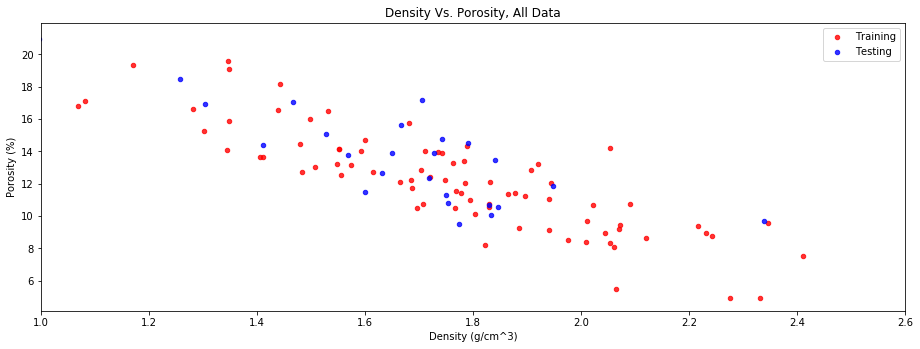

In [5]:
#This is to visulaize all the data we have
plt.subplot(111)
plt.scatter(den_train, por_train ,  color='red', s = 20, alpha = 0.8, label="Training")
plt.scatter(den_test, por_test ,  color='blue', s = 20, alpha = 0.8, label="Testing")
plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
plt.title('Density Vs. Porosity, All Data')
plt.xlim(1.,2.6)
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

## Building an initial ridge regression model

* We will build an initial ridge regression model with lambda=1. At this stage we have not done any model hyperparameter tuning yet. We may compare the behavior of this model with the final tuned one. 

Coefficients:  -7.825, Intercept:  25.958
Variance explained: 0.55
Residual: mean = -0.72, standard deviation = 3.22


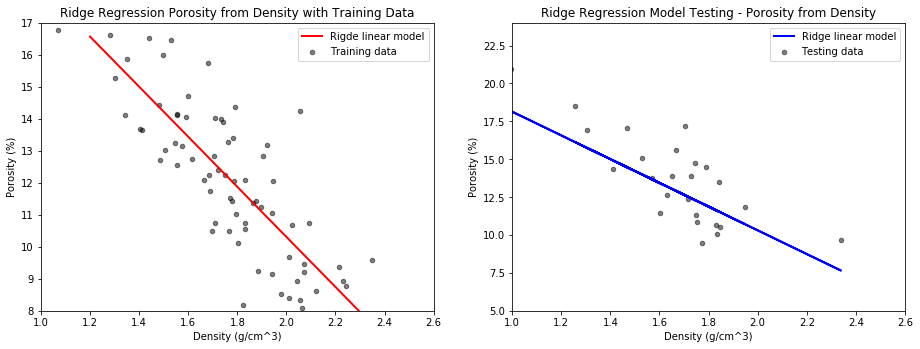

In [6]:
#Building the ridge regression model was taught by Prof. Pyrcz in PGE383, Fall2021

#Fitting a Ridge regression to the data

lam = 1.0                #lam is the Regularization hyperparameter 

# Step 1. Instantiate the Model 
ridge_reg = Ridge(alpha=lam)

# Step 2: Fit the Data on Training Data
ridge_reg.fit(df_train["Density"].values.reshape(n_train,1), df_train["Porosity"]) # fit model
density_model = np.linspace(1.2,2.4,10)

# Print the model parameters
porosity_ridge_model = ridge_reg.predict(density_model.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(ridge_reg.coef_[0],3)) + ', Intercept: ', str(round(ridge_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt.scatter(df_train["Density"].values, df_train["Porosity"],  color='black', s = 20, alpha = 0.5, label= 'Training data')
plt.plot(density_model,porosity_ridge_model, color='red', linewidth=2, label= 'Rigde linear model')
plt.title('Ridge Regression Porosity from Density with Training Data'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
plt.xlim(1.,2.6); plt.ylim(8,17)
plt.legend()
# Step 3: - Make predictions using the testing dataset
y_pred = ridge_reg.predict(df_test['Density'].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['Porosity'].values, y_pred))


# Plot testing diagnostics 
plt.subplot(122)
plt.scatter(df_test['Density'].values, df_test['Porosity'].values,  color='black', s = 20, alpha = 0.5, label='Testing data')
plt.plot(df_test['Density'], y_pred, color='blue', linewidth=2, label='Ridge linear model')
plt.title('Ridge Regression Model Testing - Porosity from Density'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
plt.xlim(1.0,2.6); plt.ylim(5,24)
plt.legend()
y_res = y_pred - df_test['Porosity'].values

print('Residual: mean = ' + str(round(np.average(y_res),2)) + ', standard deviation = ' + str(round(np.var(y_res),2)))


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

## Bootstrap

* The bootstrap method is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. We will be using this method to creat different realizations of the single training data set we have. By doing so, we will be able to test the sensitivity of our model to the training data and assess the model varaince. 

* I will create 300 realization of the training data set we chose initially. I will then assign these realizations to a new DataFrame for further visualization. 

* We need to make sure that we allow sampling with replacement in our sampling technique. 


In [7]:
##Creating different realizations of original training data set (Bootstrap)

R=[]
L=300                                                   #number of realizations
nsample=80                                              #number of chosen sample per each realization==length of training data set
for l in range(0, L):                                   # loop over all bootstrap realization
    sample= df_train.sample(n = nsample, replace=True)  #replace=True means we allow sampling with replacement
    R.append(sample)

train_df = pd.DataFrame(np.array(R). reshape(80,600))  #Combine all the realizations in one DataFrame 
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,2.231986,8.924206,1.897087,11.245838,2.216014,9.376752,1.664854,12.096567,1.530699,16.476751,...,1.945380,12.071144,1.721330,12.411608,1.864561,11.357547,2.053913,8.340399,2.044451,8.936061
1,2.119652,8.614564,2.216014,9.376752,1.438900,16.529857,1.615384,12.743846,2.119652,8.614564,...,1.506767,13.021878,2.242330,8.778226,2.053701,14.230930,1.976909,8.513227,2.119652,8.614564
2,1.785165,12.042695,1.348847,15.877907,1.498495,16.000381,2.090105,10.743471,1.742534,13.901152,...,2.009664,8.403008,1.664854,12.096567,1.438900,16.529857,1.766823,10.485052,1.885087,9.242607
3,1.783736,13.393518,1.830085,10.561222,1.766823,10.485052,2.022877,10.672887,1.703635,12.826021,...,1.885087,9.242607,1.897087,11.245838,1.897087,11.245838,1.708322,10.728462,1.721330,12.411608
4,1.830085,10.561222,1.681666,15.748318,1.789746,14.356083,1.768993,11.531035,1.762359,13.274823,...,1.592216,14.049593,1.684449,12.244806,1.479878,14.443138,1.344084,14.105901,1.976909,8.513227


## Check the distribution of the variables after Bootstrap
* Here, I am using a kernel density estimate (KDE) plot for visualizing the distribution of density and porosity varaibles. KDE represents the data using a continuous probability density curve in one or more dimensions.

* In this method, a continuous curve (the kernel) is drawn at every individual data point and all of these curves are then added together to make a single smooth density estimation.

* A probability density plot simply means a density plot of probability density function (Y-axis) vs data points of a variable (X-axis).

* A density plot is a smoothed, continuous version of a histogram estimated from the data. (Admond Lee, 2019, https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab)


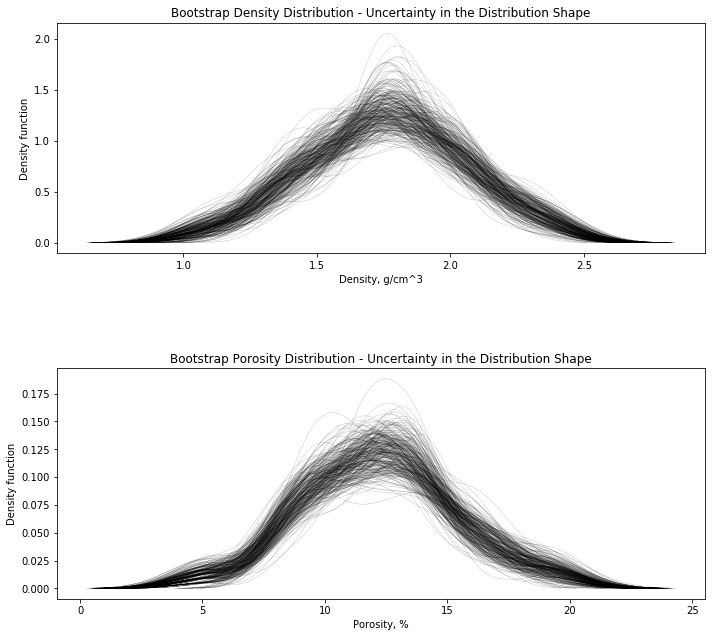

In [8]:
#Check the destribution of density variable for different realizations 
plt.subplot(211)
for i in range(0,600,2):              # loop over the realizations and plot with seaborn package
    # Draw the density plot
    sns.kdeplot(train_df[i],color = 'black',fill=False,alpha = 0.01,linewidth=0.1)

plt.title('Bootstrap Density Distribution - Uncertainty in the Distribution Shape')
plt.xlabel('Density, g/cm^3')
plt.ylabel('Density function')

#Check the destribution of density variable for different realizations 
plt.subplot(212)
for m in range(1,600,2):              # loop over the realizations and plot with seaborn package
    # Draw the density plot
    sns.kdeplot(train_df[m],color = 'black',fill=False,alpha = 0.01,linewidth=0.1)

plt.title('Bootstrap Porosity Distribution - Uncertainty in the Distribution Shape')
plt.xlabel('Porosity, %')
plt.ylabel('Density function')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=2, wspace=0.2, hspace=0.5)
plt.show()

* The above two plots show the wide distribution of the variables we have. This assures the validity of the bootstrap process to create various different models.

## Building different models for different bootstrapped data sets

* We will train the same ridge regression model (same lambda=1) over different training data sets generated from the above bootstrap process. Then each model will be used to predict the porosity values from density and compared to the unique testing data set. 

* It is expected to have different models with different parameters (slope & intercept). Moreover, the ability of these models to fit the testing data set shall vary.

* We plot the first three models below against both the training and testing data used to build and test those models. 


* *The basics of the code was taught by prof. Pyrcz during his course PGE383, Fall2021, UT Austin*


Coefficients of Model 1:  -7.983, Intercept:  26.196
Variance explained in model 1: 0.55

Coefficients of Model 2:  -6.955, Intercept:  24.324
Variance explained in model 2: 0.49

Coefficients of Model 3:  -7.742, Intercept:  25.861
Variance explained in model 3: 0.56


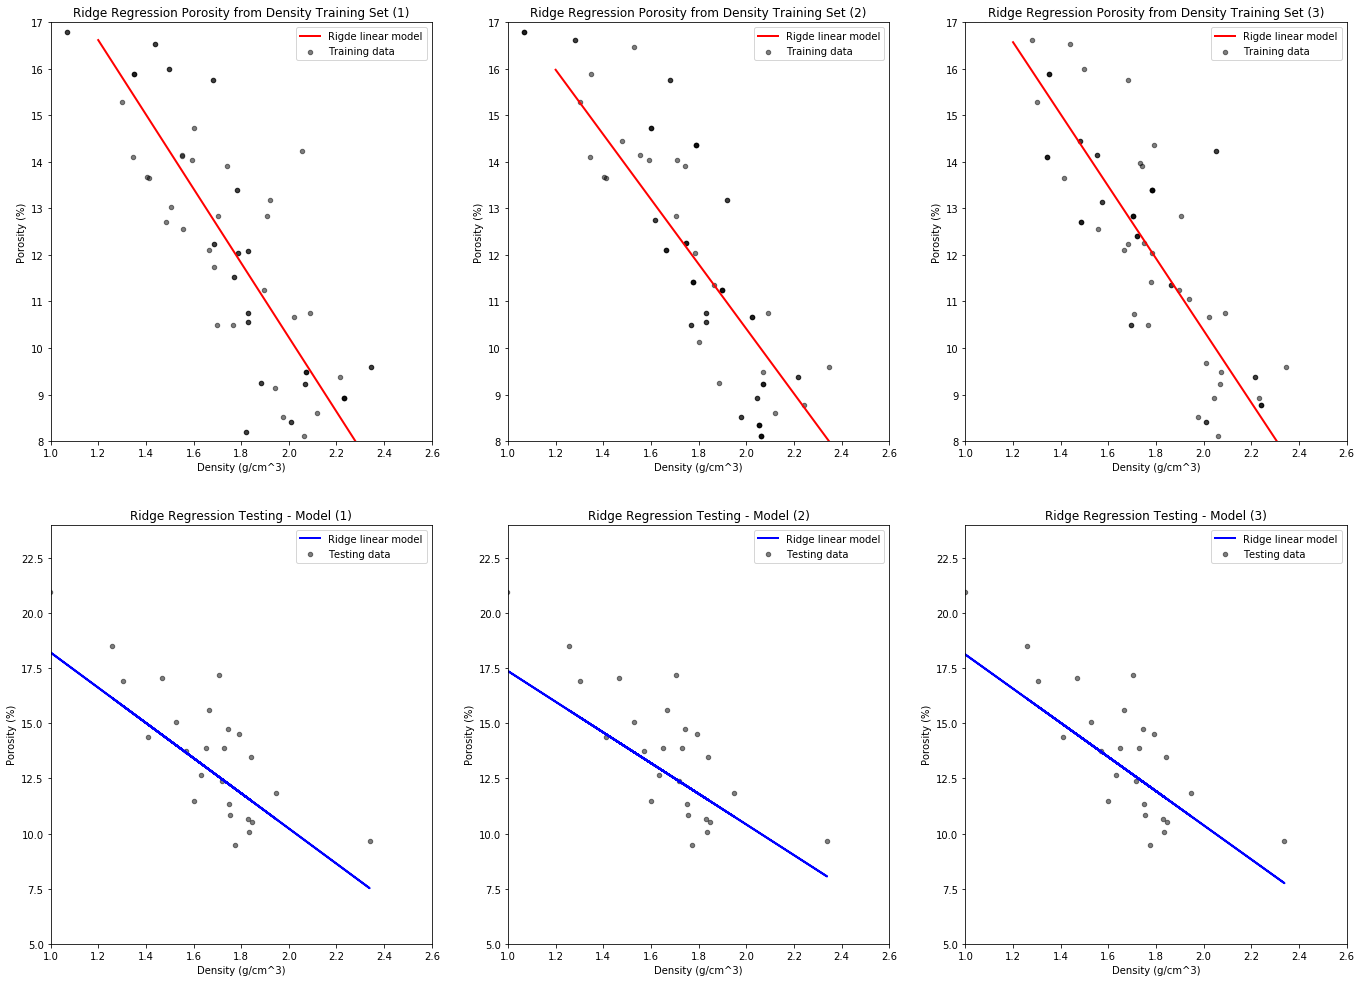

In [9]:
# Step 1. Instantiate the Model 
ridge_reg = Ridge(alpha=1)
density_model = np.linspace(1.2,2.4,10)

# Step 2: Fit the Data on Training Data

for i, j,k,l in zip((0,2,4), (1,3,5),(1,2,3),(4,5,6)):
    ridge_reg.fit(train_df.iloc[:,i].values.reshape(n_train,1), train_df.iloc[:,j]) # fit model
    porosity_ridge_model = ridge_reg.predict(density_model.reshape(10,1)) # predict with the fit model
    plt.subplot(2,3,k)
    plt.scatter(train_df.iloc[:,i].values, train_df.iloc[:,j],  color='black', s = 20, alpha = 0.5, label= 'Training data')
    plt.plot(density_model,porosity_ridge_model, color='red', linewidth=2, label= 'Rigde linear model')
    plt.title('Ridge Regression Porosity from Density Training Set ('+str(k)+')'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
    plt.xlim(1.,2.6); plt.ylim(8,17)
    plt.legend()
    #Step 3: - Make predictions using the testing dataset
    y_pred = ridge_reg.predict(df_test['Density'].values.reshape(n_test,1))
    # Plot testing diagnostics 
    plt.subplot(2,3,l)
    plt.scatter(df_test['Density'].values, df_test['Porosity'].values,  color='black', s = 20, alpha = 0.5, label='Testing data')
    plt.plot(df_test['Density'], y_pred, color='blue', linewidth=2, label='Ridge linear model')
    plt.title('Ridge Regression Testing - Model ('+str(k)+')'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
    plt.xlim(1.0,2.6); plt.ylim(5,24)
    plt.legend()
    
    print('\nCoefficients of Model '+str(k)+ ': ', str(round(ridge_reg.coef_[0],3)) + ', Intercept: ', str(round(ridge_reg.intercept_,3)))
    print('Variance explained in model '+str(k)+': %.2f' % r2_score(df_test['Porosity'].values, y_pred))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

It is clear from the plot of the training data that we have duplicated points. This is expected from the bootstrap process as we sample with replacement. However, we have only one testing data set that is used to judge the model behavior. Since we train our model on different realizations, we are expecting different models with different slopes and intercepts as shown above. 

## Model Variance Vs. Model Bias

The total expected testing error can be divided down into three components; the model bias, the model variance and the irreducible error. This is can be described in the below relation;
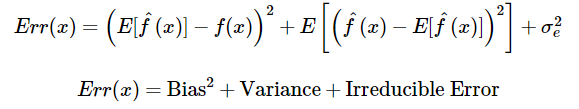

### Variance

Model variance can be described as the sensetivity of our model to the training data used to buld the model. Model with high variance is very sensitive to training data and does not generalize on the data which it has not  seen before. As a result, such models gives low error over the training data while perform badly over the testing data set. 

One of the major reasons for high model variance is the model complexity. Complex model (e.g. high order polynomial functions, ridge model with low λ hyperparameter,..) usually results in high model variance (overfitting) unlike simpler models.  


Mathematically, the variance error in the model is:

$$ E[(f ̂(x)-E[f ̂(x)])^2 ]$$


### Bias

Model bias is that kind of error that arises from the model being too simple to capture all the changes in the data. For example, choosing the expected value (the mean) to be our model (underfitting model). The bias is commonly defined as the difference between the expected value of the estimator (the average of our model predictions)  and the parameter that we want to estimate (the actual testing point).

Mathematically, the bias error in the model is:
$$ \left(E\left[\hat{f}\left(x\right)\right]-f\left(x\right)\right) $$

### Irreducible error/noise
Irreducible error is the error that can’t be reduced by creating good models. It is a measure of the amount of noise in our data. The source of noise can be measurement error, human error, instrument error,..etc. 

Mathematically, the irreducible error in the model is: variance in the testing data

$$σ^2$$

Here, we will use the Bootstrap concept along with the variation in the λ hyperparameter to calculate the model variance and bias over the different data realizations we created.


In [10]:
#Calculate the Variance by hand in the model slope over different lambda over different realizations

L = 300                                                     # the number of bootstrap realizations 
nsamples = 80                                               # the number of samples in each bootstrap realization
nlambda = 100                                               # number of lambda values to evaluate
coef_mat = np.zeros(L)                                      # declare arrays to store the results
model_var=np.zeros(L)                                       #model_var is the variance resulted from each realization
model_bias=np.zeros(L)                                      #model_bias is the bias resulted from each realization
model_mse=np.zeros(L)                                       #model_mse is the mean square error resulted from each realization
model_noise=np.zeros(L)

variance_coef = np.zeros(nlambda)
y_var=np.zeros(nlambda)
y_bias= np.zeros(nlambda)
y_mse=np.zeros(nlambda)
y_noise=np.zeros(nlambda)
lamd_mat = np.linspace(0,100.0,nlambda)
                 
for ilam in range(0,len(lamd_mat)):                         # loop over all lambda values                   
    for l in range(0, L):                                   # loop over all bootstrap realizations
        df_sample = df_train.sample(n = nsamples, replace=True)                 # random sample (1 bootstrap)
        ridge_reg = Ridge(alpha=lamd_mat[ilam])             # instatiate model
        ridge_reg.fit(df_sample["Density"].values.reshape(nsamples,1), df_sample["Porosity"]) # fit model
        ridge_predict = ridge_reg.predict(den_test.reshape(n_test,1))
        coef_mat[l] = ridge_reg.coef_[0]                    # get the slope parameter
        model_var[l]=np.var(ridge_predict)
        model_bias[l]=np.mean((por_test-np.mean(ridge_predict))**2)
        model_mse[l]=mean_squared_error(por_test,ridge_predict)
        model_noise[l]=np.var(por_test)
    y_var[ilam] = np.mean(model_var)                     #Varaince error in all realization at specific lambda value
    y_bias[ilam]=np.mean(model_bias)                     #Bias error in all realization at specific lambda value
    y_mse[ilam]=np.mean(model_mse)                       #MSE error in all realization at specific lambda value
    y_noise[ilam]=np.mean(model_noise)
    variance_coef[ilam] = np.var(coef_mat)               # calculate the variance of the slopes over the L bootstraps
Error=y_var+y_bias+y_noise                               #Total expected testin error  


## Comparison to linear regression
* Ridge regression is simply a linear regression with an added regularization term. Once this term is removed, we go back to the original linear regression. So, putting lambda=0 is simply the results of our linear regression model as we will show in the below plotting

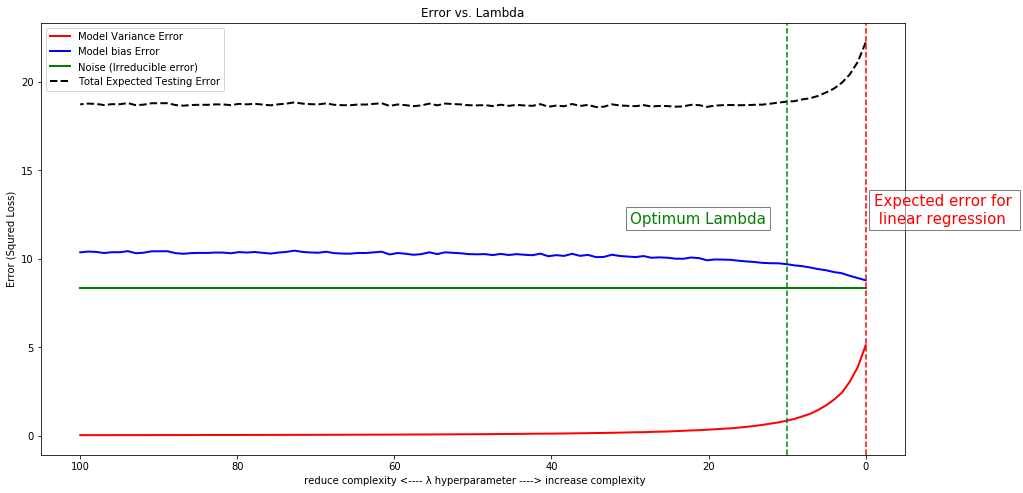

In [11]:
plt.subplot(111)
plt.plot(lamd_mat, y_var,  color='red', linewidth = 2, label = 'Model Variance Error')
plt.plot(lamd_mat, y_bias,  color='blue', linewidth = 2, label = 'Model bias Error')
plt.plot(lamd_mat, y_noise,  color='green', linewidth = 2, label = 'Noise (Irreducible error)')
plt.plot(lamd_mat, Error,  color='black', linewidth = 2, label = 'Total Expected Testing Error',linestyle='dashed')

plt.axvline(x=0, color='red', linestyle='--')                #error value with linear regression @lambda=0
plt.axvline(x=10, color='green', linestyle='--')               #the optimum lambda value for the lowest error @lambda=10

plt.text(-1, 12, 'Expected error for \n linear regression',fontsize = 15,color = 'r', 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.text(30, 12, 'Optimum Lambda',fontsize = 15,color = 'g', 
         bbox = dict(facecolor = 'white', alpha = 0.5))
plt.title('Error vs. Lambda'); plt.xlabel(' reduce complexity <---- λ hyperparameter ----> increase complexity'); plt.ylabel('Error (Squred Loss)')
plt.gca().invert_xaxis()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.2)
plt.legend()
plt.legend(loc='upper left')

## Applying the tuned hyperparameter to the original data set and compare to linear regression

Here we build both linear and ridge linear models (with λ=10) to compare their performance over the original data. As expected, the linear model comes with higher variance explained unlike the tuned ridge model that tends to honor model simplicity to avoid overfitting. 

Linear Model Slope:  -8.961, Intercept:  27.958
Ridge Model Slope:  -3.655, Intercept:  18.619
Variance explained (Linear model): 0.58
Variance explained (Ridge model): 0.26


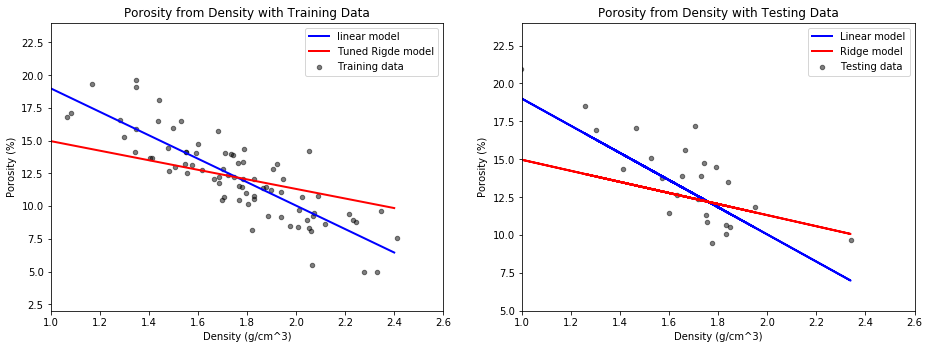

In [12]:
# Step 1. Instantiate the Models 
ridge_reg = Ridge(alpha=10)                                 # instantiate the ridge regression model
linear_reg = LinearRegression()                             # instantiate the linear regression model
# Step 2: Fit the Data on Training Data
linear_reg.fit(df_train["Density"].values.reshape(n_train,1), df_train["Porosity"]) # fit model
ridge_reg.fit(df_train["Density"].values.reshape(n_train,1), df_train["Porosity"]) # fit model
density_model = np.linspace(0.9,2.4,10)

# Print the model parameters
porosity_ridge_model = ridge_reg.predict(density_model.reshape(10,1)) # predict with the fit ridge model
porosity_linear_model = linear_reg.predict(density_model.reshape(10,1)) # predict with the fit linear model
print('Linear Model Slope: ', str(round(linear_reg.coef_[0],3)) + ', Intercept: ', str(round(linear_reg.intercept_,3))) 
print('Ridge Model Slope: ', str(round(ridge_reg.coef_[0],3)) + ', Intercept: ', str(round(ridge_reg.intercept_,3))) 
# Plot model fit
plt.subplot(121)
plt.scatter(df_train["Density"].values, df_train["Porosity"],  color='black', s = 20, alpha = 0.5, label= 'Training data')
plt.plot(density_model,porosity_linear_model, color='blue', linewidth=2, label= 'linear model')
plt.plot(density_model,porosity_ridge_model, color='red', linewidth=2, label= 'Tuned Rigde model')
plt.title('Porosity from Density with Training Data'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
plt.xlim(1.,2.6); plt.ylim(2,24)
plt.legend()
# Step 3: - Make predictions using the testing dataset
y_pred_linear=  linear_reg.predict(df_test['Density'].values.reshape(n_test,1))   #predictions from linear model
y_pred_ridge = ridge_reg.predict(df_test['Density'].values.reshape(n_test,1))     #predictions from ridge model

# Report the goodness of fit
print('Variance explained (Linear model): %.2f' % r2_score(df_test['Porosity'].values, y_pred_linear))
print('Variance explained (Ridge model): %.2f' % r2_score(df_test['Porosity'].values, y_pred_ridge))


# Plot testing diagnostics 
plt.subplot(122)
plt.scatter(df_test['Density'].values, df_test['Porosity'].values,  color='black', s = 20, alpha = 0.5, label='Testing data')
plt.plot(df_test['Density'], y_pred_linear, color='blue', linewidth=2, label='Linear model')
plt.plot(df_test['Density'], y_pred_ridge, color='red', linewidth=2, label='Ridge model')

plt.title('Porosity from Density with Testing Data'); plt.xlabel('Density (g/cm^3)'); plt.ylabel('Porosity (%)')
plt.xlim(1.0,2.6); plt.ylim(5,24)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()




* The plots above show the variation of the model variance, bias, noise, and the total expected testing error with the Lambda hyperparameter. As expected, the increase in Lambda leads to a more simple model with lower variance. However, at the same time, the model bias increases (underfitting model). This is what we call "Variance-Bias Trade-Off". 

* We also tuned the lambda hyperparameter that can give us the least error for the ridge regression models. 

### In summary, what we did is

1. Created Different realizations of the training data set we have using Bootstrap.
2. Created numerous ridge regression models for each realization
3. Calculate the model variance, bias, and total expected error for each model created.
4. Tuned the lambda hyperparameter based on the lowest expected testing error. 

### Findings

* Adding a shrinkage/ penalty factor to the linear regression model produced a more robust, stable, simple model.

### Comments

* Model Variance-Bias trade-off is a serious issue that we should account for in each model we build. Addressing this issue leads to more robust models, enhances the model prediction capability, and reduces the overall testing expected error.  



__Greetings!__

*Ibrahim Gomaa*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

